# Loading Dependencies and Dataset

In [1]:
import kagglehub
import os, glob, random, shutil
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from PIL import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

import kagglehub

# Download latest version
path = kagglehub.dataset_download("nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone")

print("Path to dataset files:", path)

2025-10-25 06:44:47.088816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761374687.111481     216 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761374687.118372     216 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Path to dataset files: /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone


In [2]:
base_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone"
# List everything inside
print(os.listdir(base_path))

['kidneyData.csv', 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone']


##  Root of dataset

In [3]:
# Root of dataset
root = os.path.join(base_path, "CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone")

# Check CSV for metadata (optional, if needed for custom loading)
csv_path = os.path.join(base_path, "kidneyData.csv")
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print("CSV columns:", df.columns)
    print("CSV head:\n", df.head())

# Automatically find folder with class subdirectories
def find_deepest_category_dir(root):
    for dirpath, dirnames, filenames in os.walk(root):
        if any(d.lower() in ['normal', 'cyst', 'tumor', 'stone'] for d in dirnames):
            return dirpath
    return root  

source_dir = find_deepest_category_dir(root)
print("✅ Found source directory:", source_dir)

CSV columns: Index(['Unnamed: 0', 'image_id', 'path', 'diag', 'target', 'Class'], dtype='object')
CSV head:
    Unnamed: 0       image_id  \
0           0  Tumor- (1044)   
1           1    Tumor- (83)   
2           2   Tumor- (580)   
3           3  Tumor- (1701)   
4           4  Tumor- (1220)   

                                                path   diag  target  Class  
0  /content/data/CT KIDNEY DATASET Normal, CYST, ...  Tumor       3  Tumor  
1  /content/data/CT KIDNEY DATASET Normal, CYST, ...  Tumor       3  Tumor  
2  /content/data/CT KIDNEY DATASET Normal, CYST, ...  Tumor       3  Tumor  
3  /content/data/CT KIDNEY DATASET Normal, CYST, ...  Tumor       3  Tumor  
4  /content/data/CT KIDNEY DATASET Normal, CYST, ...  Tumor       3  Tumor  
✅ Found source directory: /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone


## Split images into train/validation

In [4]:
# Output directories
base_dir = "/kaggle/working/organized_data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Detect categories
categories = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
print("✅ Detected categories:", categories)

# Create train/val subfolders
for dir_path in [train_dir, val_dir]:
    for category in categories:
        os.makedirs(os.path.join(dir_path, category), exist_ok=True)

# Split images into train/validation (80/20)
for category in categories:
    category_path = os.path.join(source_dir, category)
    image_files = glob.glob(os.path.join(category_path, "**", "*.jpg"), recursive=True)
    random.shuffle(image_files)

    split = int(0.8 * len(image_files))
    for f in image_files[:split]:
        shutil.copy(f, os.path.join(train_dir, category))
    for f in image_files[split:]:
        shutil.copy(f, os.path.join(val_dir, category))

print("\n✅ Dataset successfully reorganized and split!")
print(f"Train folder: {train_dir}")
print(f"Validation folder: {val_dir}")

✅ Detected categories: ['Cyst', 'Tumor', 'Stone', 'Normal']

✅ Dataset successfully reorganized and split!
Train folder: /kaggle/working/organized_data/train
Validation folder: /kaggle/working/organized_data/validation


# Data cleaning and augmentation

## Remove extra/unwanted folder

In [5]:
# Remove extra/unwanted folders
for folder in ["CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"]:
    for base in [train_dir, val_dir]:
        path = os.path.join(base, folder)
        if os.path.exists(path):
            shutil.rmtree(path)
            print(f"Removed extra folder: {path}")

## Remove possible corrupted images

In [6]:
# Remove corrupted images
def remove_corrupted_images(base_path):
    num_deleted = 0
    for root, _, files in os.walk(base_path):
        for f in files:
            file_path = os.path.join(root, f)
            try:
                img = Image.open(file_path)
                img.verify()
            except (IOError, SyntaxError):
                os.remove(file_path)
                num_deleted += 1
    print(f"🧹 Removed {num_deleted} corrupted images from {base_path}")

remove_corrupted_images(train_dir)
remove_corrupted_images(val_dir)

🧹 Removed 0 corrupted images from /kaggle/working/organized_data/train
🧹 Removed 0 corrupted images from /kaggle/working/organized_data/validation


## Data augmentation and rescaling

In [7]:
# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load images
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,  
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

print("\nDetected classes (indices):")
print(train_data.class_indices)

Found 11964 images belonging to 4 classes.
Found 4500 images belonging to 4 classes.

Detected classes (indices):
{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}


# Data visualization and Exploration

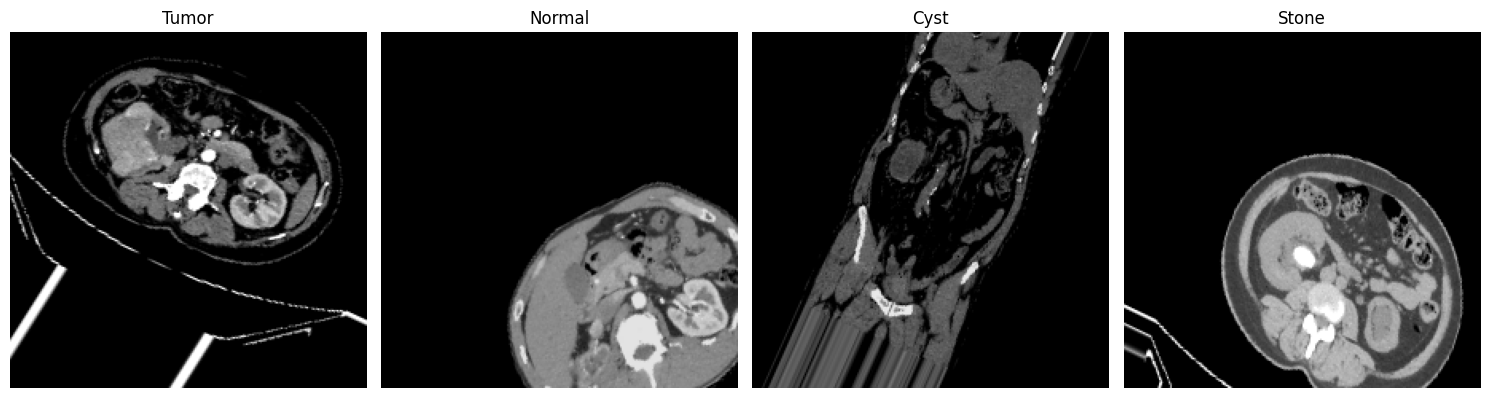

In [8]:
# Get mapping of class names and indices
class_indices = train_data.class_indices
classes = list(class_indices.keys())

# Prepare dictionary to store one image per class
sample_images = {}
sample_labels = {}

# Loop through batches until we get one sample from each class
for images, labels in train_data:
    for img, label in zip(images, labels):
        label_idx = int(label) if labels.ndim == 1 else np.argmax(label)
        class_name = classes[label_idx]

        if class_name not in sample_images:
            sample_images[class_name] = img
            sample_labels[class_name] = class_name

        # Stop when we have one image for each class
        if len(sample_images) == len(classes):
            break
    if len(sample_images) == len(classes):
        break

# Plot one sample per class
plt.figure(figsize=(15, 12))
for i, (label, img) in enumerate(sample_images.items()):
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(label, fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [9]:
images, labels = next(train_data)
print("images_train_data_shape:", images.shape)
print("laels_train_data_shape:", labels.shape)

images_train_data_shape: (64, 224, 224, 3)
laels_train_data_shape: (64, 4)


In [10]:
train_dir = "/kaggle/working/organized_data/train"
val_dir = "/kaggle/working/organized_data/validation"

def count_images_per_class(directory):
    class_counts = {}
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            class_counts[cls] = len(os.listdir(cls_path))
    return class_counts

train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)

# Combine into DataFrame
df_counts = pd.DataFrame({
    'Class': list(train_counts.keys()),
    'Train': list(train_counts.values()),
    'Validation': [val_counts.get(k, 0) for k in train_counts.keys()]
})

df_counts['Total'] = df_counts['Train'] + df_counts['Validation']
df_counts = df_counts.sort_values('Total', ascending=False)
df_counts


,Class,Train,Validation,Total
2,Normal,4878,1833,6711
1,Cyst,3566,1341,4907
3,Tumor,2190,821,3011
0,Stone,1330,505,1835


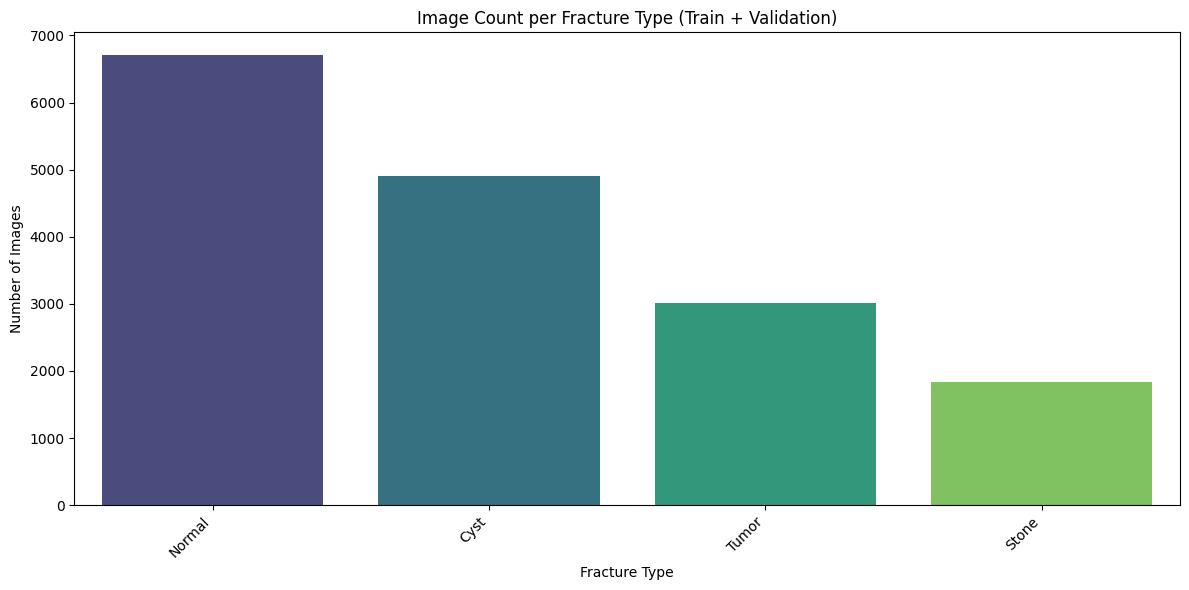

In [11]:
plt.figure(figsize=(12,6))
sns.barplot(x='Class', y='Total', data=df_counts, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Image Count per Fracture Type (Train + Validation)")
plt.xlabel("Fracture Type")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


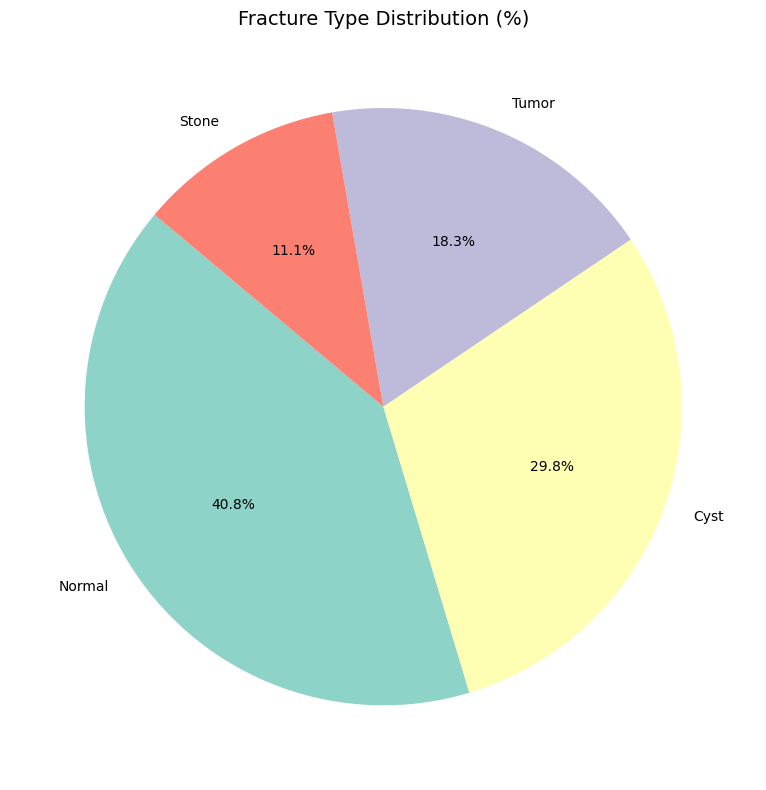

In [12]:
plt.figure(figsize=(8,8))
plt.pie(df_counts['Total'], labels=df_counts['Class'], autopct='%1.1f%%', 
        startangle=140, colors=sns.color_palette("Set3", len(df_counts)))
plt.title("Fracture Type Distribution (%)", fontsize=14)
plt.tight_layout()
plt.show()


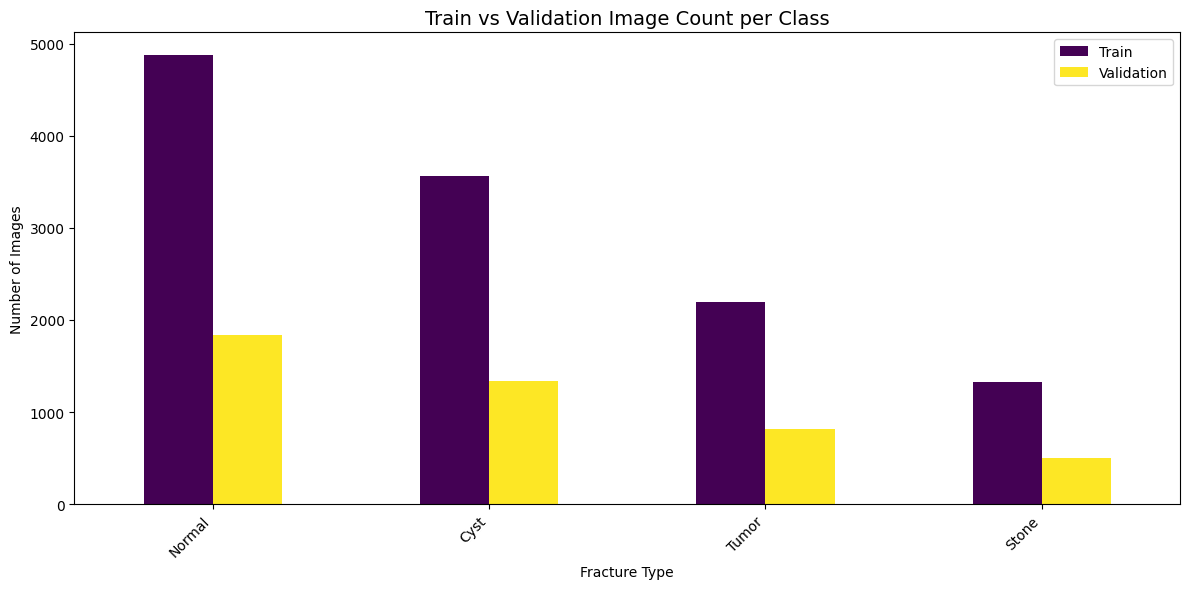

In [13]:
df_counts_plot = df_counts.set_index('Class')[['Train', 'Validation']]
df_counts_plot.plot(kind='bar', stacked=False, figsize=(12,6), colormap='viridis')
plt.title("Train vs Validation Image Count per Class", fontsize=14)
plt.xlabel("Fracture Type")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 

# Compute class weights for imbalance

In [14]:
# Compute class weights for imbalance
labels = []
for _, label_batch in train_data:
    labels.extend(np.argmax(label_batch, axis=1))
    if len(labels) >= train_data.samples:
        break

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(zip(np.unique(labels), class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 0.8373460246360582, 1: 0.6141683778234086, 2: 2.255656108597285, 3: 1.3620218579234973}


# Build model and Train

## Model preparation

In [15]:
# Load ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune last 50 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Build model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-5),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1761374878.760162     216 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761374878.760830     216 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,280,132 (187.99 MB)

 Trainable params: 49,226,500 (187.78 MB)

 Non-trainable params: 53,632 (209.50 KB)

## Model training

In [16]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-7)

# Train model
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


I0000 00:00:1761374930.539491     285 service.cc:148] XLA service 0x7bbe78005190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761374930.539524     285 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761374930.539528     285 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761374935.102238     285 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761374965.219646     285 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


187/187 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.4064 - loss: 6.9227 - val_accuracy: 0.1162 - val_loss: 6.9093 - learning_rate: 1.0000e-05
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.6799 - loss: 5.9346 - val_accuracy: 0.1744 - val_loss: 6.8362 - learning_rate: 1.0000e-05
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.7866 - loss: 5.5178 - val_accuracy: 0.2482 - val_loss: 7.1943 - learning_rate: 1.0000e-05
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8403 - loss: 5.2805 - val_accuracy: 0.3602 - val_loss: 7.6950 - learning_rate: 1.0000e-05
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.8961 - loss: 5.0639 - val_accuracy: 0.4982 - val_loss: 7.5331 - learning_rate: 1.0000e-05
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9187 - loss: 4.9003 - val_accuracy: 0.7047 - val_loss: 6.4798 - learning_rate: 1.0000e-05
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.93

# Model validation and performance check

## Model Accuracy and Loss Curve

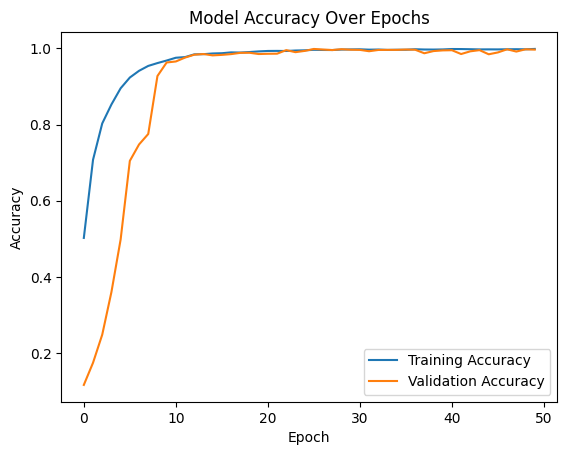

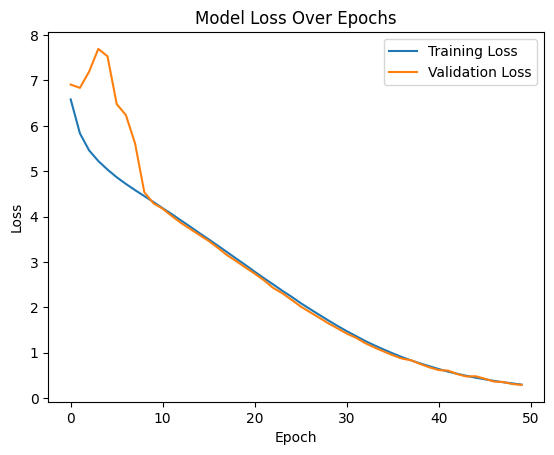

In [17]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:

val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.9991 - loss: 0.2813
Validation Accuracy: 0.9969
Validation Loss: 0.2886


## Confusion matrix and Classification report

71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step


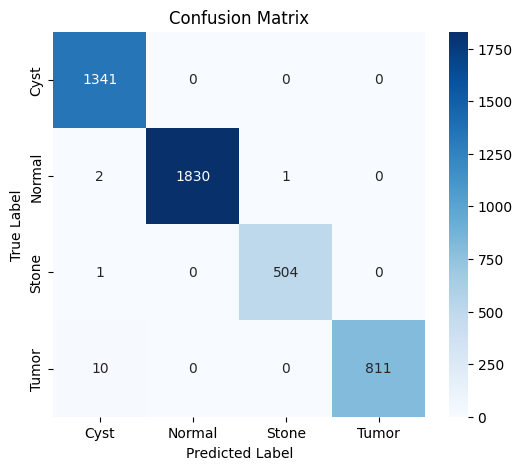


Classification Report:
              precision    recall  f1-score   support

        Cyst       0.99      1.00      1.00      1341
      Normal       1.00      1.00      1.00      1833
       Stone       1.00      1.00      1.00       505
       Tumor       1.00      0.99      0.99       821

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500



In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and class names
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

# Predict (probabilities)
y_pred = model.predict(val_data)

# Convert predictions to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))
